<a href="https://colab.research.google.com/github/dldisha/ResNet/blob/main/Visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
from prettytable import PrettyTable
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import json
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

## ResNet Architecture:

In [3]:
# N:    residual layer (default: 4)
# B_i:  residual block in layer i (default: 2)
# C_1:  channel in layer 1 (default: 64)
# F_i:  filter in residual conv (default: 3)
# K_i:  filter in connection conv (default: 1)
# P:    average pooling size (default: 1)


class DropBlock2D(nn.Module):
    r"""Randomly zeroes 2D spatial blocks of the input tensor.
    As described in the paper
    `DropBlock: A regularization method for convolutional networks`_ ,
    dropping whole blocks of feature map allows to remove semantic
    information as compared to regular dropout.
    Args:
        drop_prob (float): probability of an element to be dropped.
        block_size (int): size of the block to drop
    Shape:
        - Input: `(N, C, H, W)`
        - Output: `(N, C, H, W)`
    .. _DropBlock: A regularization method for convolutional networks:
       https://arxiv.org/abs/1810.12890
    """

    def __init__(self, drop_prob, block_size):
        super(DropBlock2D, self).__init__()

        self.drop_prob = drop_prob
        self.block_size = block_size

    def forward(self, x):
        # shape: (bsize, channels, height, width)

        assert x.dim() == 4, \
            "Expected input with 4 dimensions (bsize, channels, height, width)"

        if not self.training or self.drop_prob == 0.:
            return x
        else:
            # get gamma value
            gamma = self._compute_gamma(x)

            # sample mask
            mask = (torch.rand(x.shape[0], *x.shape[2:]) < gamma).float()

            # place mask on input device
            mask = mask.to(x.device)

            # compute block mask
            block_mask = self._compute_block_mask(mask)

            # apply block mask
            out = x * block_mask[:, None, :, :]

            # scale output
            out = out * block_mask.numel() / block_mask.sum()

            return out

    def _compute_block_mask(self, mask):
        block_mask = F.max_pool2d(input=mask[:, None, :, :],
                                  kernel_size=(self.block_size, self.block_size),
                                  stride=(1, 1),
                                  padding=self.block_size // 2)

        if self.block_size % 2 == 0:
            block_mask = block_mask[:, :, :-1, :-1]

        block_mask = 1 - block_mask.squeeze(1)

        return block_mask

    def _compute_gamma(self, x):
        return self.drop_prob / (self.block_size ** 2)


def convNxN(
        C_in,
        C_out,
        F,
        stride=1,
        groups=1,
        dilation=1,
        padding=1
) -> nn.Conv2d:
    """NxN convolution with padding"""
    return nn.Conv2d(C_in, C_out, kernel_size=F, stride=stride,
                     padding=padding, groups=groups, bias=False, dilation=dilation)


class ResBlock(nn.Module):
    def __init__(
            self,
            C_in,
            C_out,
            F,
            stride=1,
            groups=1,
            dilation=1,
            base_width=64,
            downsample=None,
            norm_layer=nn.BatchNorm2d
    ) -> None:
        super(ResBlock, self).__init__()
        if groups != 1:
            raise ValueError('BasicBlock only supports groups=1')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = convNxN(C_in=C_in, C_out=C_out, F=F, stride=stride, padding=(F - 1) // 2)
        self.bn1 = norm_layer(C_out)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = convNxN(C_in=C_out, C_out=C_out, F=F, stride=1, padding=(F - 1) // 2)
        self.bn2 = norm_layer(C_out)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
            self,
            C_1,
            N=4,
            F=[3, 3, 3, 3],
            B=[2, 2, 2, 2],
            K=[1, 1, 1, 1],
            P=1,
            num_classes=10,
            groups=1,
            width_per_group=64,
            norm_layer=nn.BatchNorm2d,
            D_P=0.,
            D_S=0,
            D_F=0.
    ) -> None:
        super(ResNet, self).__init__()
        self._norm_layer = norm_layer
        self.inplanes = C_1
        self.dilation = 1
        self.groups = groups
        self.base_width = width_per_group
        # Input Layer
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=F[0], stride=2, padding=(F[0] - 1) // 2, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(self.inplanes, self.inplanes,
                                       K[0], F[0], B[0], dropout_prob=D_P, dropout_size=D_S)
        layer2 = []
        for i in range(N - 1):
            layer2.append(self._make_layer(self.inplanes * (2 ** i),
                                           self.inplanes * (2 ** (i + 1)),
                                           K[i], F[i], B[i], stride=2,
                                           dropout_prob=D_P, dropout_size=D_S))
        self.layer2 = nn.Sequential(*layer2)
        self.avgpool = nn.AdaptiveAvgPool2d((P, P))
        final_input = int(self.inplanes * (2 ** (N - 1)) * (P ** 2))
        if D_F > 0.:
            self.fc = nn.Sequential(
                nn.Dropout(D_F),
                nn.Linear(final_input, num_classes),
            )
        else:
            self.fc = nn.Linear(final_input, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, inplanes, planes, K, F, blocks, dropout_prob=0, dropout_size=0, stride=1):
        if inplanes == planes:
            downsample = None
        else:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes, kernel_size=K, stride=stride, padding=(K - 1) // 2, bias=False),
                nn.BatchNorm2d(planes),
            )

        layers = []
        layers.append(ResBlock(inplanes, planes, F, stride, downsample=downsample))
        for _ in range(1, blocks):
            layers.append(ResBlock(planes, planes, F, downsample=None))
        if dropout_prob > 0:
            layers.append(DropBlock2D(dropout_prob, dropout_size))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        for layer in self.layer2:
            x = layer(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

if __name__ == '__main__':
    model = ResNet(128, N=1, F=[3, 3, 3, 3], B=[2, 2, 2, 2], K=[1, 1, 1, 1], P=1)
    # model = ResNet(64, N=5, F=[3 for _ in range(5)], B=[2 for _ in range(5)], K=[1 for _ in range(5)], P=1)
    images = torch.randn(10, 3, 32, 32)
    print(model)
    print(count_parameters(model) / 1000 / 1000)
    print(images.size())
    outputs = model(images)
    print(outputs.size())

ResNet(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), 

## Hyperparameter setting


In [4]:
params = {
    'batch_size': 64,
    'lr': 0.001,
    'workers': 0,
    'classes': ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
    'gpu': True,
    'epoch': 40,
}


def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=params['batch_size'], shuffle=True,
                                          num_workers=params['workers'])

testset = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=params['batch_size'], shuffle=False,
                                         num_workers=params['workers'])


def run(hp):
    name = json.dumps(hp)
    net = ResNet(**hp)
    params_size = count_parameters(net) / 1000000.
    if params_size > 5.:
        print(params_size)
        raise AssertionError
    if params['gpu']:
        net = net.cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=params['lr'])

    hp['score'] = 0.0
    hp['epoch'] = 0
    iter_ = 0
    for epoch in range(params['epoch']):
        for i, data in enumerate(trainloader):
            iter_ += 1

            inputs, labels = data
            if params['gpu']:
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if iter_ % 100 == 99:
                correct = 0
                total = 0
                with torch.no_grad():
                    for test_data in testloader:
                        inputs, labels = test_data
                        if params['gpu']:
                            inputs = inputs.cuda()
                            labels = labels.cuda()
                        outputs = net(inputs)
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()
                if hp['score'] < correct / total:
                    hp['score'] = correct / total
                    hp['epoch'] = epoch
                    torch.save(net.state_dict(), name + '.pt')
    #with open('/content/drive/MyDrive/2022-spring-deep-learning-project/parameters.json' + name + '.json', 'w') as f:
    with open('/content/drive/MyDrive/parameters.json' + name + '.json', 'w') as f:
        json.dump(hp, f)
    return hp


if __name__ == '__main__':
    hyperparams = {
        'N': 3,
        'C_1': 64,
        'P': 1,
        'B': [2, 2, 2, 2],
        'F': [3, 3, 3, 3],
        'K': [1, 1, 1, 1],
    }
    #with open('/content/drive/MyDrive/2022-spring-deep-learning-project/parameters.json', 'r') as f:
    # with open('/content/drive/MyDrive/parameters.json', 'r') as f:
    #   candidates = json.load(f)
    # for i in range(22, 43):
    #   hyperparams = candidates[str(i)]
    #   print (hyperparams)
    #   run(hyperparams)
  

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


## Hyperparameters Experiment
Using compound scaling method

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("new-results.csv")
for key in ['B', 'F', 'K']:
    items = data[key].tolist()
    items = [str(i[1]) for i in items]
    data[key] = items

# score range:
# 0 for <80
# 1 for 80 - 85
# 2 for 85 - 90
# 3 for >90

data['score'] = np.where(
   (data['score'] >= 0.70) & (data['score'] < 0.80) , 0, data['score']
   )

data['score'] = np.where(
   (data['score'] >= 0.8) & (data['score'] < 0.85) , 1, data['score']
   )

data['score'] = np.where(
   (data['score'] >= 0.85) & (data['score'] < 0.90) , 2, data['score']
   )

data['score'] = np.where(
   (data['score'] >= 0.9) & (data['score'] < 0.95) , 3, data['score']
   )

print(data.head(10))



   Unnamed: 0  N  C_1  P  B  F  K  score  epoch
0           0  1  128  1  2  3  1    2.0     48
1           1  3   32  1  1  3  1    2.0     48
2           2  3   64  2  3  3  1    2.0     45
3           3  4   16  1  2  3  1    1.0     48
4           4  2   64  1  3  5  1    2.0     46
5           5  2   64  1  2  7  5    2.0     48
6           6  2   64  1  1  5  3    2.0     48
7           7  3   16  1  3  3  1    1.0     48
8           8  2  128  2  3  3  3    3.0     42
9           9  5   16  2  1  3  1    0.0     47


In [ ]:
data.corr()

,Unnamed: 0,N,C_1,P,score,epoch
Unnamed: 0,1.000000,0.048256,-0.059715,-0.006416,-0.182269,-0.126119
N,0.048256,1.000000,-0.587654,-0.245035,-0.086695,0.064043
C_1,-0.059715,-0.587654,1.000000,0.240350,0.203561,-0.078566
P,-0.006416,-0.245035,0.240350,1.000000,-0.063813,-0.213177
score,-0.182269,-0.086695,0.203561,-0.063813,1.000000,0.182274
epoch,-0.126119,0.064043,-0.078566,-0.213177,0.182274,1.000000


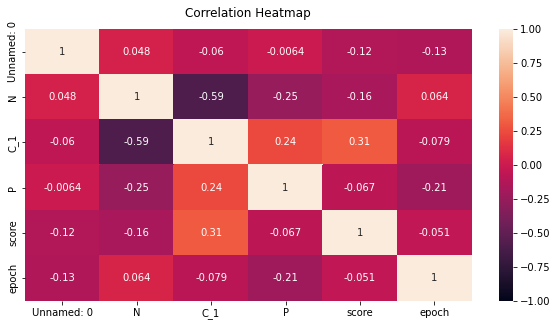

In [ ]:
plt.figure(figsize=(10, 5))
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

The correlation graph makes us conclude the N, C_1 are highly related to eachother. So, we will start

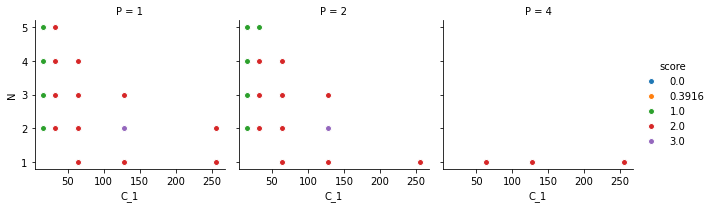

In [ ]:
graph = sns.FacetGrid(data, col ="P",  hue ="score")
# map the above form facetgrid with some attributes
graph.map(plt.scatter, "C_1", "N", edgecolor ="w").add_legend()
# show the object
plt.show()

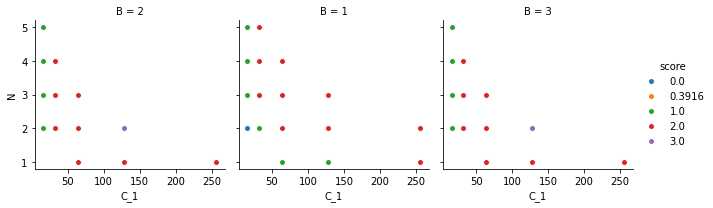

In [ ]:
graph = sns.FacetGrid(data, col ="B",  hue ="score")
# map the above form facetgrid with some attributes
graph.map(plt.scatter, "C_1", "N", edgecolor ="w").add_legend()
# show the object
plt.show()

From the above graphs, we can observe that for N=2, C_1 = 128, P=1,2 and B=2,3 we get a score of 3 which means accuracy >90%.

If we fix these conditions, we can have another graph which will help us get values for F, K.

Now we will plot graph between P, B, F, K for N=2, C_1 = 128 and score >90%.

In [ ]:
#filter dataframe
c1 = data.loc[(data['N']==2) & (data['C_1']== 128) & (data['score'] == 3)]
print(c1)

     Unnamed: 0  N  C_1  P  B  F  K  score  epoch
8             8  2  128  2  3  3  3    3.0     42
13           13  2  128  1  3  3  3    3.0     49
36           36  2  128  2  3  3  5    3.0     48
51           51  2  128  1  3  3  1    3.0     48
58           58  2  128  2  2  3  1    3.0     47
61           61  2  128  2  3  3  1    3.0     47
112         112  2  128  1  2  3  1    3.0     48
126         126  2  128  1  3  3  5    3.0     46


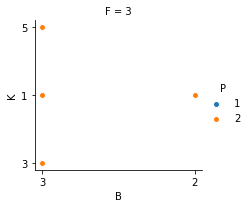

In [ ]:
graph = sns.FacetGrid(c1, col ="F",  hue ="P")
# map the above form facetgrid with some attributes
graph.map(plt.scatter, "B", "K", edgecolor ="w").add_legend()
# show the object
plt.show()

From the above graph, we get our hyperparameters as

N = 2

C_1 = 128

P = 2

B = 3

F = 3

K = [1,3,5]


## Ground Truth for Training and Validation Dataset

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


           ship             dog            deer            ship           plane           plane             cat            bird


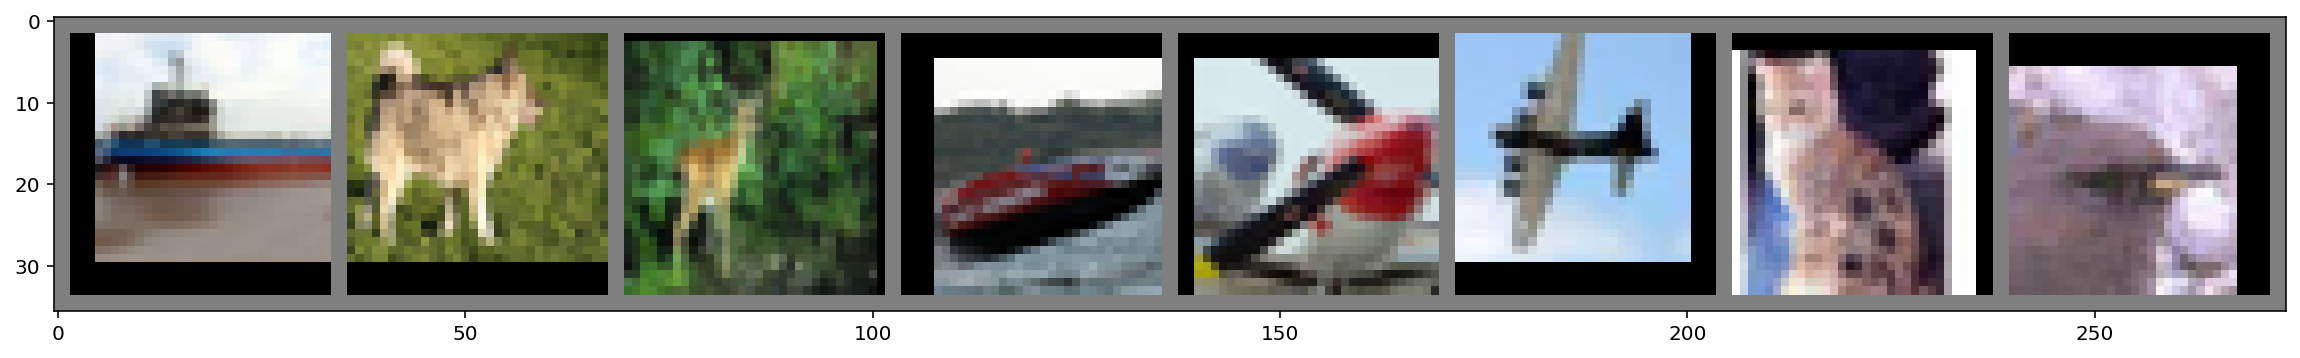

In [7]:
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                     std=[0.5, 0.5, 0.5])
training_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=64, shuffle=True,
        num_workers=4, pin_memory=True)

validation_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=128, shuffle=False,
        num_workers=4, pin_memory=True)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(training_loader)
images, labels = dataiter.next()
plt.figure(figsize=(20,10)) 

# show images
imshow(torchvision.utils.make_grid(images[0:8,:,:]))
# print labels
print(' '.join('%15s' % classes[labels[j]] for j in range(8)))

## Training and Test Error